### Libs

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [100]:
# mean percent abs error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

### Importação dos dados

In [101]:
df_data = pd.read_csv('solar-cargas-dia-fortal.csv', 
                index_col=[0],
                parse_dates=[0])
df_data.head()

,total_loads
start_of_operation,
2023-01-02,95
2023-01-03,92
2023-01-04,92
2023-01-05,100
2023-01-06,92


In [102]:
df_data.tail()

,total_loads
start_of_operation,
2025-02-19,113
2025-02-20,107
2025-02-22,20
2025-02-23,79
2025-02-24,108


In [103]:
# adicionando as datas faltantes no dataset
df_range = pd.DataFrame({'start_of_operation': pd.date_range(start='2023-01-01', end='2025-02-24')})
df_range = df_range.set_index('start_of_operation')
df_range.head()

""
start_of_operation
2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05


In [104]:
df_range.tail()

""
start_of_operation
2025-02-20
2025-02-21
2025-02-22
2025-02-23
2025-02-24


In [105]:
# concatenando os datasets 

df = pd.concat([df_data, df_range], axis=1).reindex(df_range.index)
df['total_loads'] = df['total_loads'].fillna(0)# preechendo os valores nulos com zero

df.head(10)

,total_loads
start_of_operation,
2023-01-01,0.0
2023-01-02,95.0
2023-01-03,92.0
2023-01-04,92.0
2023-01-05,100.0
2023-01-06,92.0
2023-01-07,25.0
2023-01-08,61.0
2023-01-09,109.0


### Visualização geral

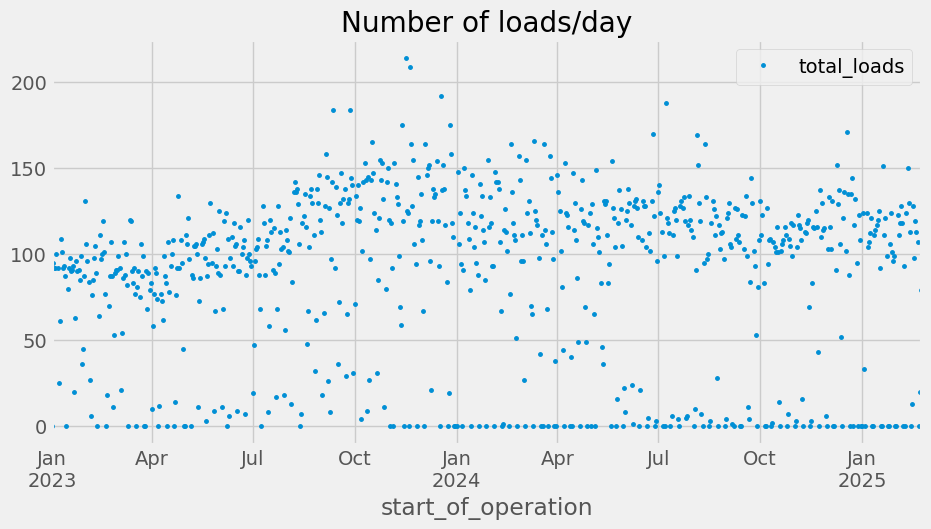

In [106]:
palette_color = sns.color_palette()
df.plot(style='.',
       figsize=(10,5),
       ms=5,
       color=palette_color[0],
       title='Number of loads/day')
plt.show()

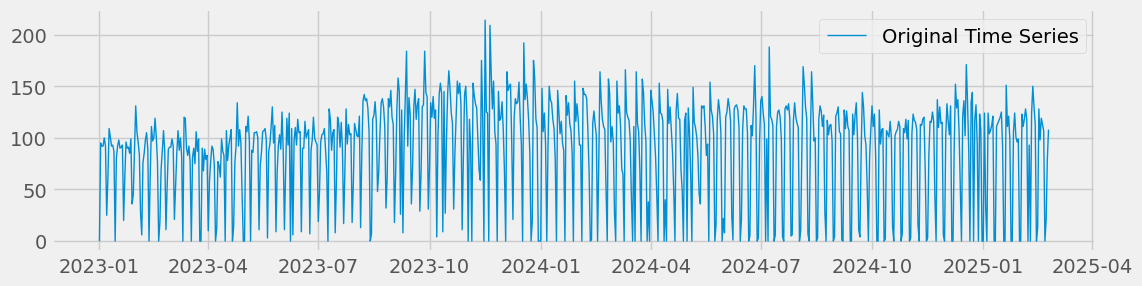

In [107]:
plt.figure(figsize=(12,3))
plt.plot(df, label='Original Time Series', linewidth=1)
plt.legend()
plt.show()

In [108]:
df_teste = df[df.index<'2025-01-01']
df_teste.tail()

,total_loads
start_of_operation,
2024-12-27,95.0
2024-12-28,0.0
2024-12-29,123.0
2024-12-30,108.0
2024-12-31,0.0


<Figure size 1800x300 with 0 Axes>

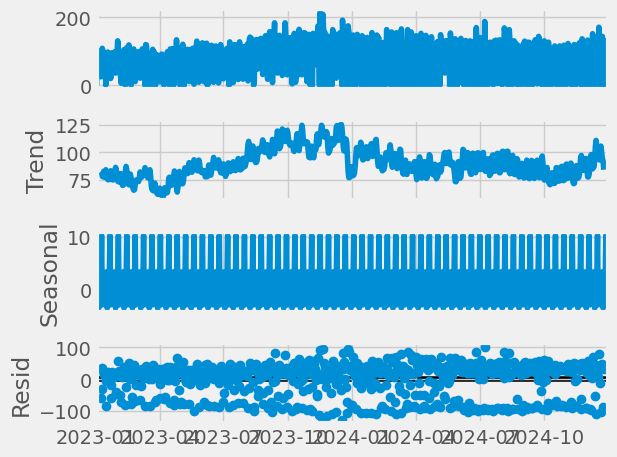

In [109]:
decompose_orig = seasonal_decompose(df[df.index<'2025-01-01'], model='additive', period=12)
plt.figure(figsize=(18,3))
decompose_orig.plot().show()

### Time Series Features

In [110]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday',
                                       'Wednesday', 
                                       'Thursday', 'Friday',
                                       'Saturday', 'Sunday'], 
                           ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    # df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    # df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    # df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
    #                       labels=['Spring', 'Summer', 'Fall', 'Winter']
                   # )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='total_loads')
features_and_target = pd.concat([X, y], axis=1)

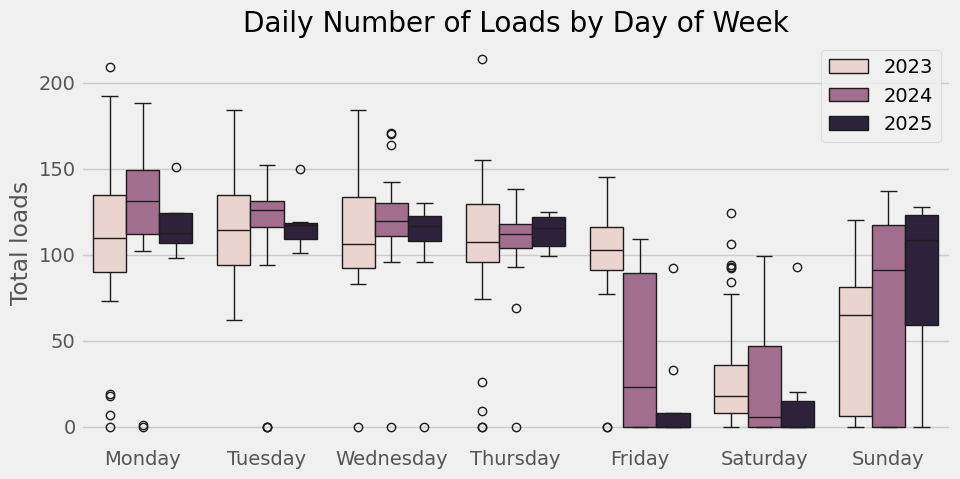

In [111]:
# grouped by week
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='total_loads',
            hue='year',
            ax=ax,
            linewidth=1)
ax.set_title('Daily Number of Loads by Day of Week')
ax.set_xlabel('')
ax.set_ylabel('Total loads')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

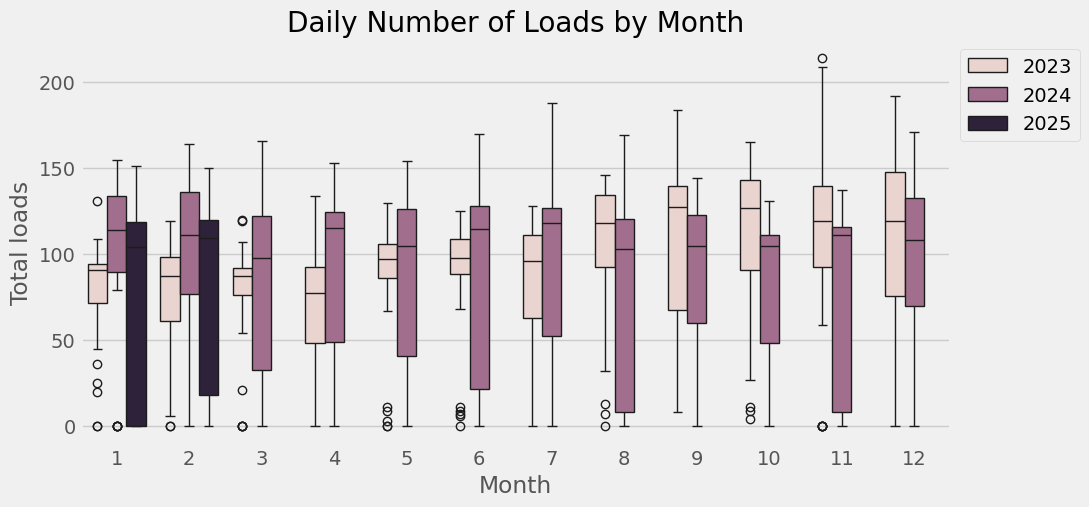

In [112]:
# grouped by month
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='month',
            y='total_loads',
            hue='year',
            ax=ax,
            linewidth=1)
ax.set_title('Daily Number of Loads by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Total loads')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [113]:
features_and_target.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,total_loads
start_of_operation,,,,,,,,,
2023-01-01,6,1,1,2023,1,1,52,Sunday,0.0
2023-01-02,0,1,1,2023,2,2,1,Monday,95.0
2023-01-03,1,1,1,2023,3,3,1,Tuesday,92.0
2023-01-04,2,1,1,2023,4,4,1,Wednesday,92.0
2023-01-05,3,1,1,2023,5,5,1,Thursday,100.0


## Predições por Dia

### Separando os dados de treino e teste

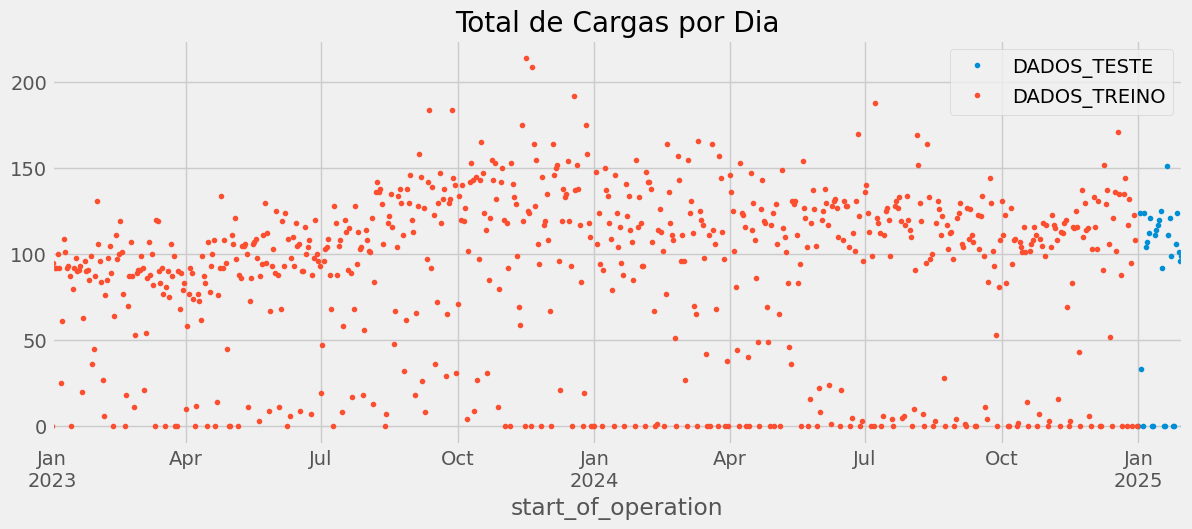

In [114]:
split_date = '2025-01-01'
df_train = df.loc[df.index < split_date].copy()
df_test = df.loc[(df.index >= split_date) & (df.index < '2025-02-01')].copy()

df_test\
    .rename(columns={'total_loads':'DADOS_TESTE'})\
    .join(df_train.rename(columns={'total_loads':'DADOS_TREINO'}),
         how='outer')\
    .plot(figsize=(13,5), title='Total de Cargas por Dia', style='.')
plt.show()

### Treinando o modelo

In [115]:
df_train_prophet = df_train.reset_index()\
                           .rename(columns={'start_of_operation':'ds',
                                            'total_loads':'y'})
df_train_prophet.head()

,ds,y
0,2023-01-01,0.0
1,2023-01-02,95.0
2,2023-01-03,92.0
3,2023-01-04,92.0
4,2023-01-05,100.0


In [116]:
model = Prophet()
model.fit(df_train_prophet)

15:30:42 - cmdstanpy - INFO - Chain [1] start processing
15:30:42 - cmdstanpy - INFO - Chain [1] done processing


### Predições

In [117]:
df_test_prophet = df_test.reset_index()\
                           .rename(columns={'start_of_operation':'ds',
                                            'total_loads':'y'})
df_test_fcst = model.predict(df_test_prophet)

In [118]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-01-01,74.842085,50.716681,138.260172,74.842085,74.842085,20.617834,20.617834,20.617834,26.673283,26.673283,26.673283,-6.055449,-6.055449,-6.055449,0.0,0.0,0.0,95.459919
1,2025-01-02,74.771128,47.115881,135.760571,74.771128,74.771128,12.815705,12.815705,12.815705,19.714921,19.714921,19.714921,-6.899216,-6.899216,-6.899216,0.0,0.0,0.0,87.586833
2,2025-01-03,74.700171,6.953068,94.111427,74.700171,74.700171,-24.178079,-24.178079,-24.178079,-16.614421,-16.614421,-16.614421,-7.563657,-7.563657,-7.563657,0.0,0.0,0.0,50.522092
3,2025-01-04,74.629214,-34.107011,51.558793,74.629214,74.629214,-69.939247,-69.939247,-69.939247,-61.897106,-61.897106,-61.897106,-8.042141,-8.042141,-8.042141,0.0,0.0,0.0,4.689967
4,2025-01-05,74.558257,-6.039808,86.207728,74.558257,74.558257,-35.368658,-35.368658,-35.368658,-27.036769,-27.036769,-27.036769,-8.331890,-8.331890,-8.331890,0.0,0.0,0.0,39.189599


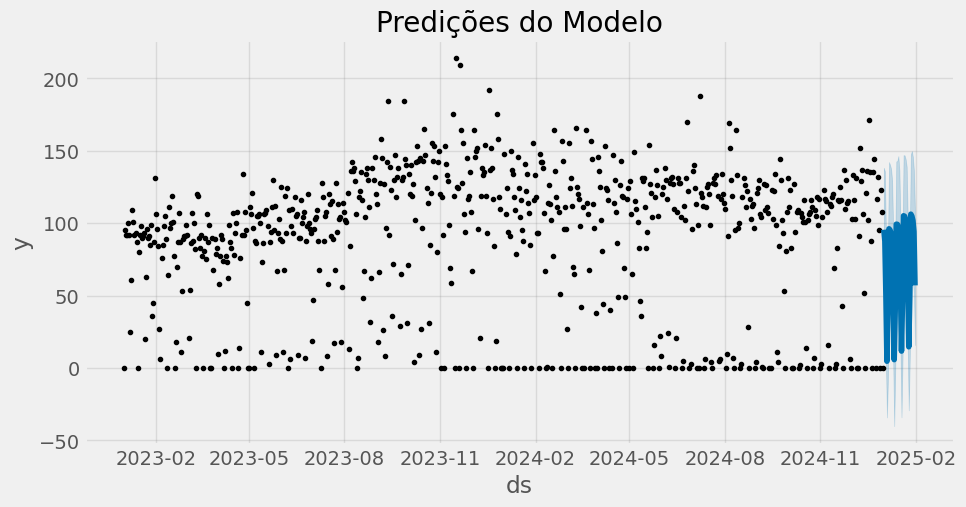

In [119]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(df_test_fcst, ax=ax)
ax.set_title('Predições do Modelo')
plt.show()

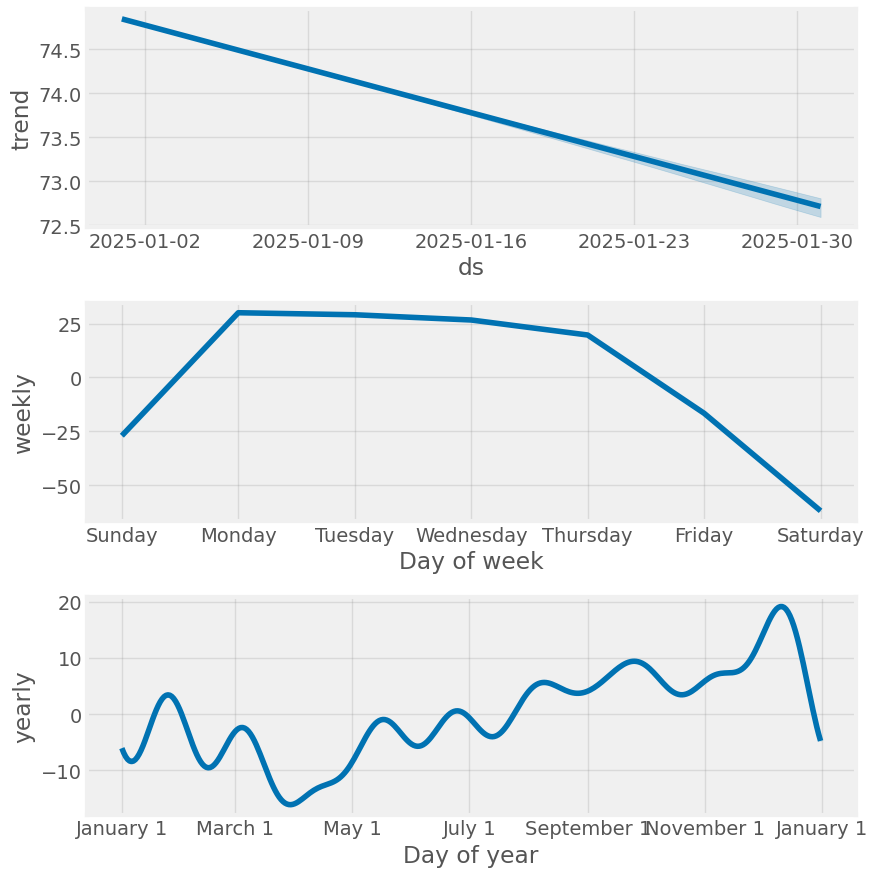

In [120]:
fig = model.plot_components(df_test_fcst)
plt.show()

### Comparando os resultados

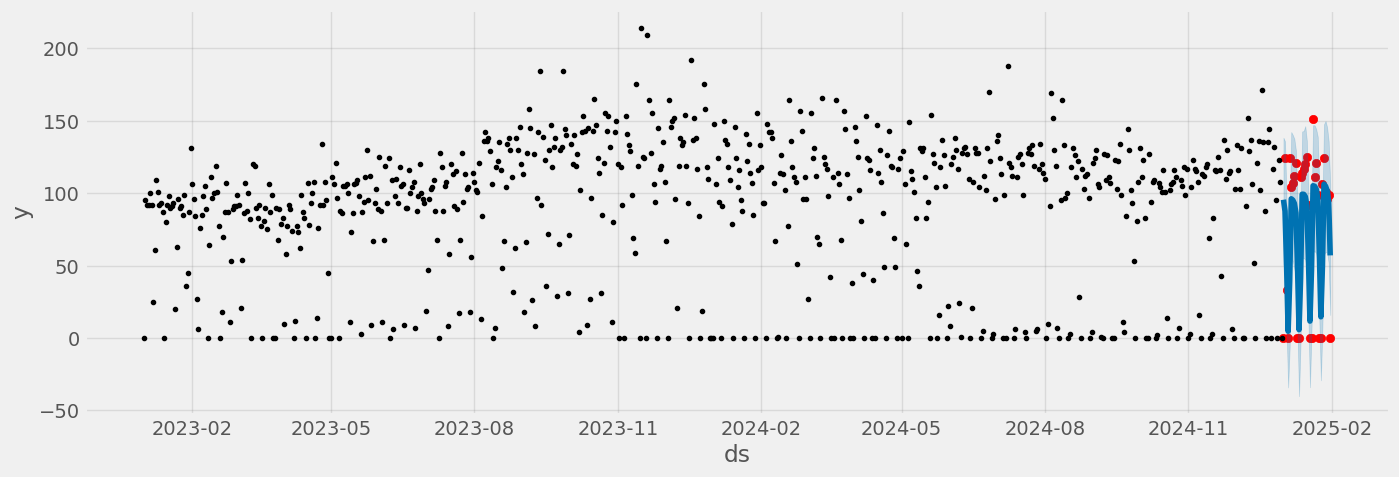

In [121]:
f,ax = plt.subplots(figsize=(15,5))
ax.scatter(df_test.index, df_test['total_loads'], color='r')
fig=model.plot(df_test_fcst, ax=ax)

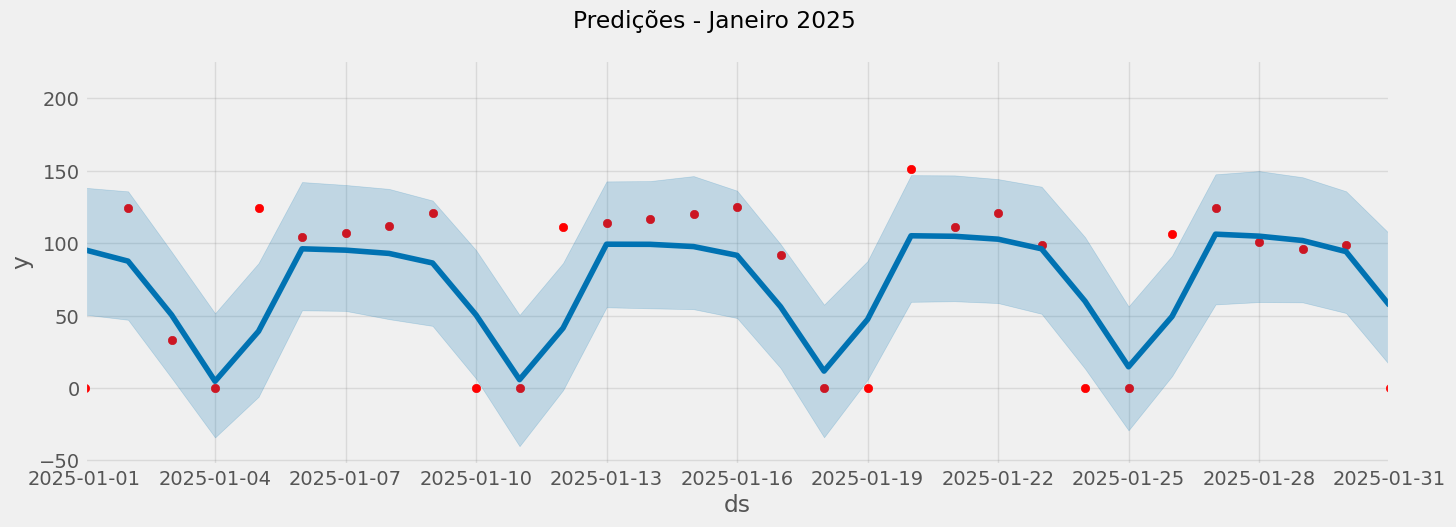

In [122]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(df_test.index, df_test['total_loads'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2025'),
             upper=pd.to_datetime('01-31-2025'))
# ax.set_ylim()
plot = plt.suptitle('Predições - Janeiro 2025')

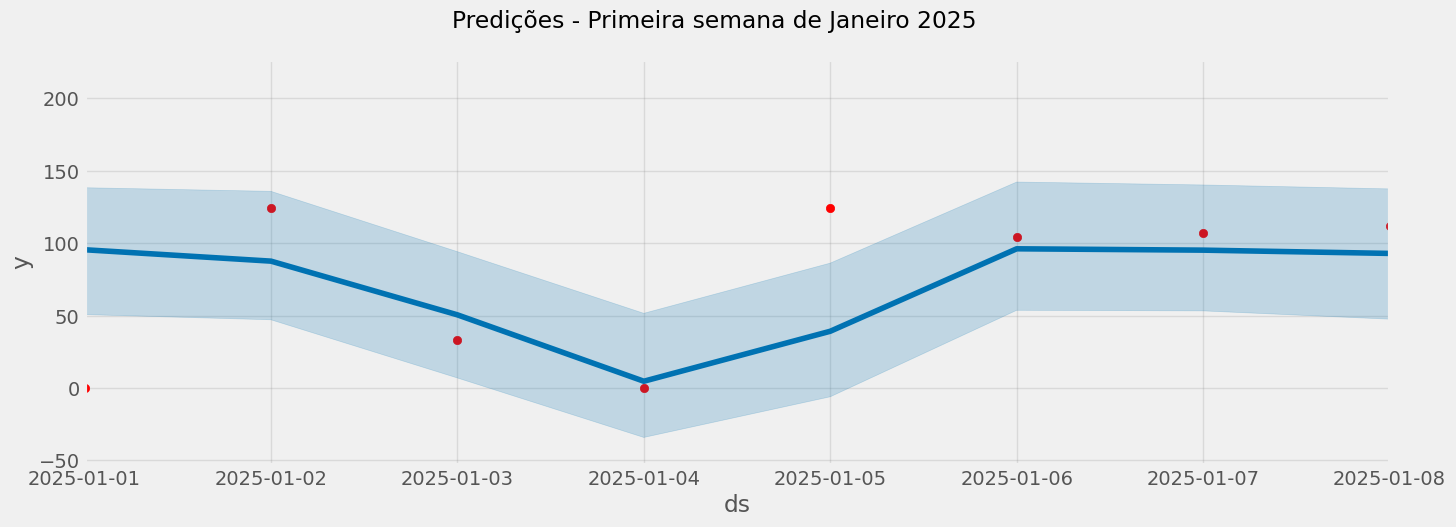

In [123]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(df_test.index, df_test['total_loads'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2025'),
             upper=pd.to_datetime('01-08-2025'))
# ax.set_ylim()
plot = plt.suptitle('Predições - Primeira semana de Janeiro 2025')

### Métricas de Erro do Modelo

In [124]:
rmse = np.sqrt(mean_squared_error(y_true=df_test['total_loads'],
                          y_pred = df_test_fcst['yhat']))
str(rmse)

'38.56752004301045'

In [125]:
mae = mean_absolute_error(y_true=df_test['total_loads'],
                         y_pred=df_test_fcst['yhat'])
mae

29.525707068768675

In [126]:
mape = mean_absolute_percentage_error(y_true=df_test['total_loads'],
                         y_pred=df_test_fcst['yhat'])
mape

np.float64(inf)

### Aproximando para uma previsão mensal

In [127]:
df_approx_mensal = df_test_fcst[['ds','yhat_lower', 'yhat_upper', 'yhat']]
df_approx_mensal.head()

,ds,yhat_lower,yhat_upper,yhat
0,2025-01-01,50.716681,138.260172,95.459919
1,2025-01-02,47.115881,135.760571,87.586833
2,2025-01-03,6.953068,94.111427,50.522092
3,2025-01-04,-34.107011,51.558793,4.689967
4,2025-01-05,-6.039808,86.207728,39.189599


In [128]:
# inserindo 0 nos valores negativos de yhat_lower
df_approx_mensal['yhat_lower'] = [0 if x < 0 else x for x in df_approx_mensal['yhat_lower'].values]
df_approx_mensal.head()

,ds,yhat_lower,yhat_upper,yhat
0,2025-01-01,50.716681,138.260172,95.459919
1,2025-01-02,47.115881,135.760571,87.586833
2,2025-01-03,6.953068,94.111427,50.522092
3,2025-01-04,0.000000,51.558793,4.689967
4,2025-01-05,0.000000,86.207728,39.189599


In [129]:
df_approx_mensal['mes'] = df_approx_mensal['ds'].dt.month
df_approx_mensal['ano'] = df_approx_mensal['ds'].dt.year

df_approx_mensal.head()

,ds,yhat_lower,yhat_upper,yhat,mes,ano
0,2025-01-01,50.716681,138.260172,95.459919,1,2025
1,2025-01-02,47.115881,135.760571,87.586833,1,2025
2,2025-01-03,6.953068,94.111427,50.522092,1,2025
3,2025-01-04,0.000000,51.558793,4.689967,1,2025
4,2025-01-05,0.000000,86.207728,39.189599,1,2025


In [130]:
df_approx_mensal['mes_ano'] = df_approx_mensal['mes'].astype(str)+'-'+df_approx_mensal['ano'].astype(str)
df_approx_mensal['mes_ano'] = pd.to_datetime(df_approx_mensal['mes_ano'])
df_approx_mensal.head()

,ds,yhat_lower,yhat_upper,yhat,mes,ano,mes_ano
0,2025-01-01,50.716681,138.260172,95.459919,1,2025,2025-01-01
1,2025-01-02,47.115881,135.760571,87.586833,1,2025,2025-01-01
2,2025-01-03,6.953068,94.111427,50.522092,1,2025,2025-01-01
3,2025-01-04,0.000000,51.558793,4.689967,1,2025,2025-01-01
4,2025-01-05,0.000000,86.207728,39.189599,1,2025,2025-01-01


In [131]:
predicao_mensal = df_approx_mensal.groupby(['mes_ano'], as_index=False)\
                                  .agg({'yhat':'sum',
                                         'yhat_lower':'sum',
                                         'yhat_upper':'sum'})
predicao_mensal

,mes_ano,yhat,yhat_lower,yhat_upper
0,2025-01-01,2245.268014,1036.437422,3613.236694


In [158]:
df_month[df_month['month_year']=='2025-01-01']

,year,month,total_loads,month_year
24,2025,1,2412.0,2025-01-01


In [133]:
# plt.plot(predicao_mensal['yhat'])

In [134]:
df_test_fcst['yhat'].sum()

np.float64(2245.2680136410254)

## Predições por Mês

### Agrupando dados por mês e por semana

In [135]:
df_month = features_and_target.groupby(['year','month'], as_index=False)['total_loads'].sum()
df_month.head()

,year,month,total_loads
0,2023,1,2426.0
1,2023,2,2054.0
2,2023,3,2348.0
3,2023,4,2035.0
4,2023,5,2608.0


In [136]:
df_month.shape

(26, 3)

In [137]:
df_month['month_year'] = df_month['month'].astype(str)+'-'+df_month['year'].astype(str)
df_month['month_year'] = pd.to_datetime(df_month['month_year'])
df_month.head()

,year,month,total_loads,month_year
0,2023,1,2426.0,2023-01-01
1,2023,2,2054.0,2023-02-01
2,2023,3,2348.0,2023-03-01
3,2023,4,2035.0,2023-04-01
4,2023,5,2608.0,2023-05-01


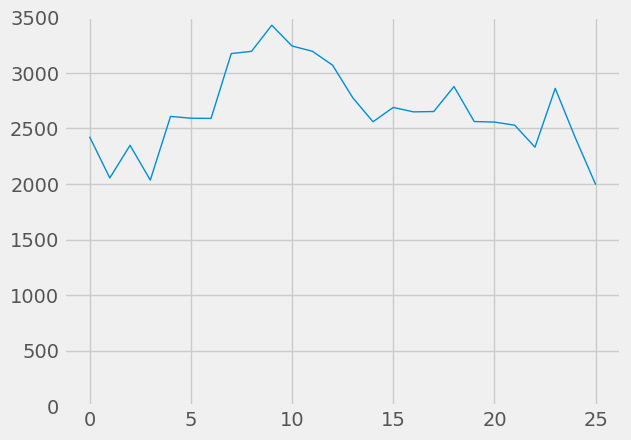

In [138]:
df_month['total_loads'].plot(linewidth=1)
plt.ylim(0,3500)
plt.show()

In [139]:
df_week = features_and_target.groupby(['year','weekofyear'], as_index=False)['total_loads'].sum()
df_week.head()

,year,weekofyear,total_loads
0,2023,1,557.0
1,2023,2,562.0
2,2023,3,547.0
3,2023,4,542.0
4,2023,5,537.0


In [140]:
df_week.shape

(113, 3)

In [141]:
df_week.dtypes

year             int32
weekofyear      UInt32
total_loads    float64
dtype: object

<Axes: >

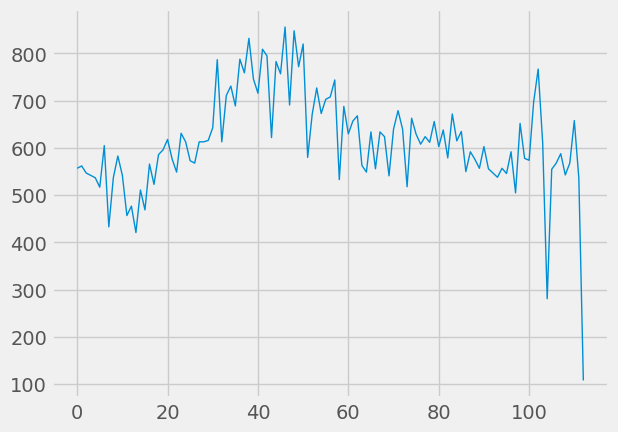

In [142]:
df_week['total_loads'].plot(linewidth=1)

### Treinando o modelo

In [143]:
df_train = df_month.loc[df_month['month_year']<'01-2025', ['month_year','total_loads']]
df_train.tail()

,month_year,total_loads
19,2024-08-01,2562.0
20,2024-09-01,2557.0
21,2024-10-01,2529.0
22,2024-11-01,2331.0
23,2024-12-01,2860.0


In [144]:
df_train_decomp = df_train.set_index('month_year')
df_train_decomp.tail()

,total_loads
month_year,
2024-08-01,2562.0
2024-09-01,2557.0
2024-10-01,2529.0
2024-11-01,2331.0
2024-12-01,2860.0


In [145]:
df_test = df_month.loc[(df_month['month_year']>='01-2025')&(df_month['month_year']<'02-2025'), ['month_year','total_loads']]
df_test_decomp = df_test.set_index('month_year')
df_test_decomp

,total_loads
month_year,
2025-01-01,2412.0


### Decomposing the training data

https://medium.com/towards-data-science/getting-started-predicting-time-series-data-with-facebook-prophet-c74ad3040525#:~:text=Conclusion,enhance%20your%20time%20series%20forecasting.

https://www.geeksforgeeks.org/time-series-decomposition-techniques/

In [146]:
decompose = seasonal_decompose(df_train_decomp, model='additive')


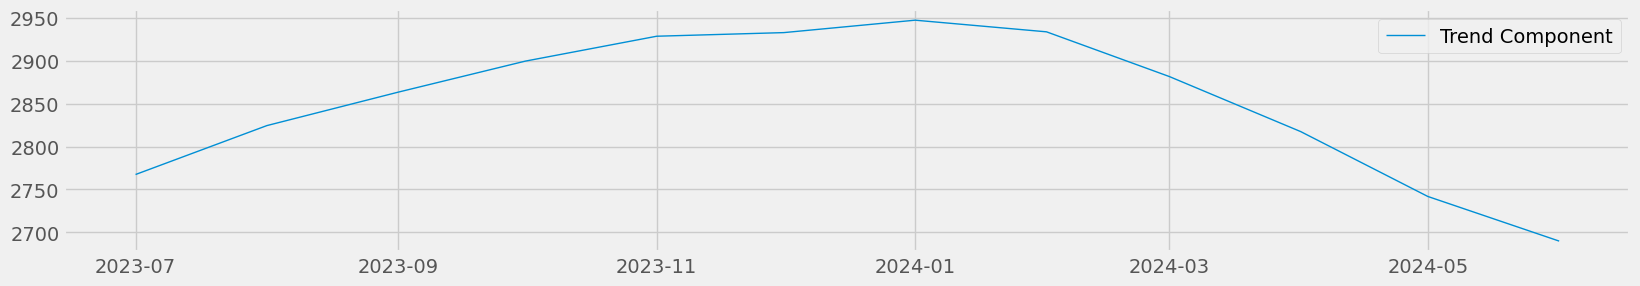

In [147]:
plt.figure(figsize=(18, 3))

plt.plot(decompose.trend, label='Trend Component', linewidth=1)
plt.legend(loc='upper right')
plt.show()

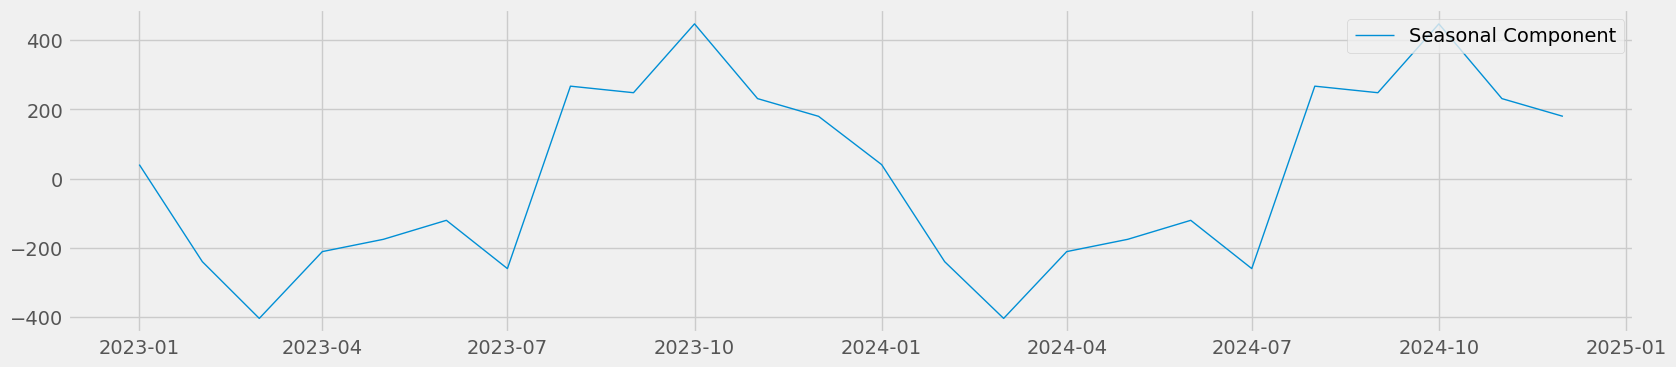

In [148]:
plt.figure(figsize=(18, 4))

plt.plot(decompose.seasonal, label='Seasonal Component', linewidth=1)
plt.legend(loc='upper right')
plt.show()

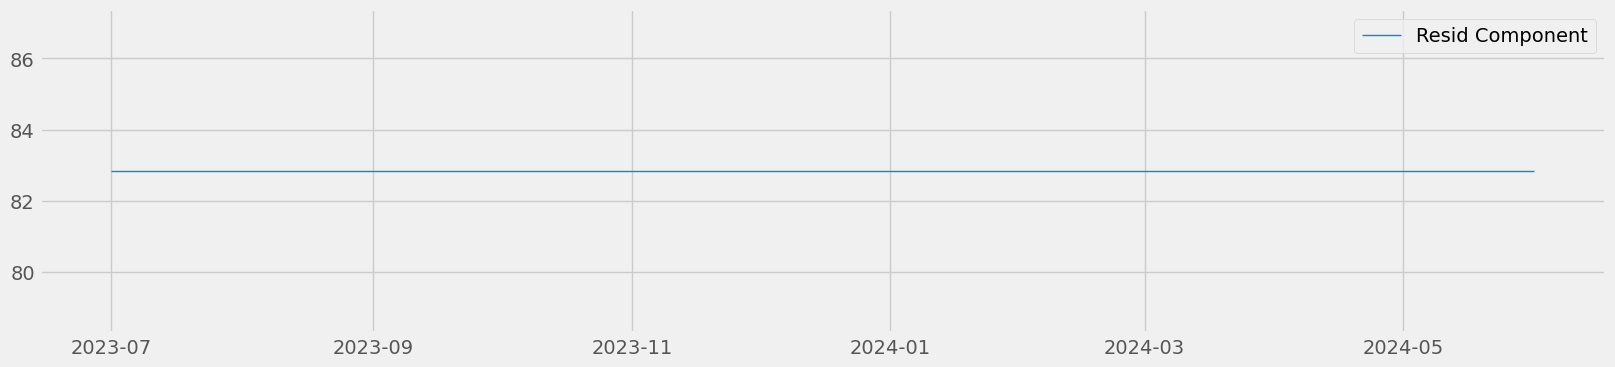

In [149]:
plt.figure(figsize=(18, 4))

plt.plot(decompose.resid, label='Resid Component', linewidth=1)
plt.legend(loc='upper right')
plt.show()

### Simple Model

In [150]:
# renaming the columns according to prophet's config

df_train_prophet = df_train.copy()

df_train_prophet = df_train_prophet.rename(columns = {'month_year':'ds'})
df_train_prophet = df_train_prophet.rename(columns = {'total_loads':'y'})
df_train_prophet

,ds,y
0,2023-01-01,2426.0
1,2023-02-01,2054.0
2,2023-03-01,2348.0
3,2023-04-01,2035.0
4,2023-05-01,2608.0
5,2023-06-01,2592.0
6,2023-07-01,2590.0
7,2023-08-01,3174.0
8,2023-09-01,3194.0
9,2023-10-01,3429.0


In [151]:
model_prophet  = Prophet()
model_prophet.fit(df_train_prophet)

15:30:43 - cmdstanpy - INFO - Chain [1] start processing
15:30:43 - cmdstanpy - INFO - Chain [1] done processing


#### Predições

In [152]:
df_future = model_prophet.make_future_dataframe(periods=1, freq='MS')
display(df_future)

,ds
0,2023-01-01
1,2023-02-01
2,2023-03-01
3,2023-04-01
4,2023-05-01
5,2023-06-01
6,2023-07-01
7,2023-08-01
8,2023-09-01
9,2023-10-01


In [153]:
forecast_prophet = model_prophet.predict(df_future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
20,2024-09-01,2774.0,2347.0,3233.0
21,2024-10-01,2781.0,2362.0,3190.0
22,2024-11-01,2789.0,2317.0,3238.0
23,2024-12-01,2797.0,2365.0,3216.0
24,2025-01-01,2804.0,2331.0,3285.0


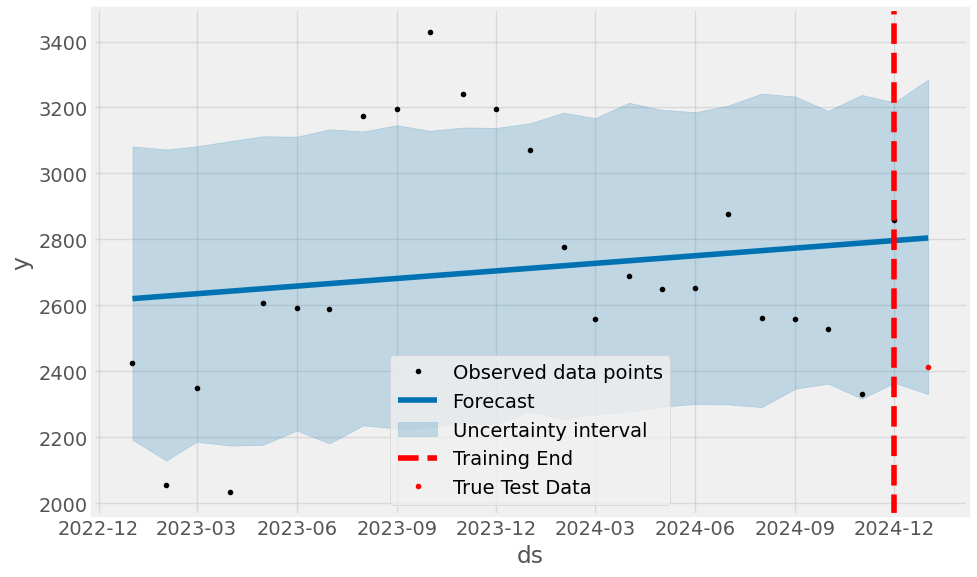

In [154]:

# plot the time series 
forecast_plot = model_prophet.plot(forecast_prophet)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-2]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line
# df_test['month_year'] = pd.to_datetime(df_test['month_year'])
plt.plot(df_test['month_year'], df_test['total_loads'],'ro', markersize=3, label='True Test Data')

# show the legend to distinguish between the lines
plt.legend()